# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [52]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option("display.max_rows", None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of answers
keras.utils.set_random_seed(42)


In [35]:
data = pd.read_csv('../data/AAPL_2009-2010_6m_RAW_1d.csv')

In [36]:
print("Num of null values: ", data.isnull().sum())

Num of null values:  Date          0
Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64


In [37]:
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,3.717500,3.892857,3.710357,3.881786,3.281867,5.893720e+08
1,2009-04-02,3.933571,4.098214,3.920714,4.025357,3.403249,8.123668e+08
2,2009-04-03,4.078214,4.147500,4.054286,4.142500,3.502286,6.362412e+08
3,2009-04-06,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,4.122500,4.171071,4.092143,4.154286,3.512252,4.556300e+08
6,2009-04-09,4.229286,4.285714,4.212857,4.270357,3.610385,5.307568e+08
7,2009-04-13,4.286071,4.320714,4.250000,4.293571,3.630010,3.892364e+08
8,2009-04-14,4.270357,4.291786,4.187500,4.225357,3.572339,4.546220e+08
9,2009-04-15,4.185714,4.223214,4.134286,4.201429,3.552110,4.128824e+08


In [38]:
# Index data by Date
data.set_index('Date', inplace=True)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,3.717500,3.892857,3.710357,3.881786,3.281867,5.893720e+08
2009-04-02,3.933571,4.098214,3.920714,4.025357,3.403249,8.123668e+08
2009-04-03,4.078214,4.147500,4.054286,4.142500,3.502286,6.362412e+08
2009-04-06,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-08,4.122500,4.171071,4.092143,4.154286,3.512252,4.556300e+08
2009-04-09,4.229286,4.285714,4.212857,4.270357,3.610385,5.307568e+08
2009-04-13,4.286071,4.320714,4.250000,4.293571,3.630010,3.892364e+08
2009-04-14,4.270357,4.291786,4.187500,4.225357,3.572339,4.546220e+08


<Axes: xlabel='Date'>

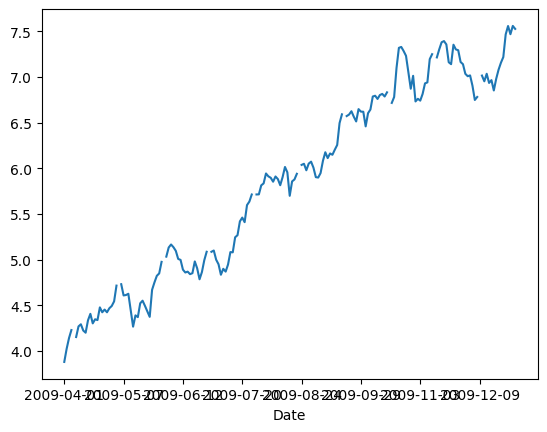

In [39]:
data['Close'].plot()

In [40]:
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64


In [41]:
# forward fill missing values
data=data.ffill()
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,3.717500,3.892857,3.710357,3.881786,3.281867,5.893720e+08
2009-04-02,3.933571,4.098214,3.920714,4.025357,3.403249,8.123668e+08
2009-04-03,4.078214,4.147500,4.054286,4.142500,3.502286,6.362412e+08
2009-04-06,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08
2009-04-07,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08
2009-04-08,4.122500,4.171071,4.092143,4.154286,3.512252,4.556300e+08
2009-04-09,4.229286,4.285714,4.212857,4.270357,3.610385,5.307568e+08
2009-04-13,4.286071,4.320714,4.250000,4.293571,3.630010,3.892364e+08
2009-04-14,4.270357,4.291786,4.187500,4.225357,3.572339,4.546220e+08


In [42]:
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# 2. Define Features (Copy from training code)

In [43]:
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_lower'] = data['MA20'] - (data['STD20'] * 2)
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['Vol20'] = data['Log_Ret'].rolling(window=20).std() * np.sqrt(252)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,STD20,BB_upper,BB_lower,Log_Ret,Vol20
Date,,,,,,,,,,,,,
2009-04-01,3.717500,3.892857,3.710357,3.881786,3.281867,5.893720e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-02,3.933571,4.098214,3.920714,4.025357,3.403249,8.123668e+08,NaN,NaN,NaN,NaN,NaN,0.036318,NaN
2009-04-03,4.078214,4.147500,4.054286,4.142500,3.502286,6.362412e+08,NaN,NaN,NaN,NaN,NaN,0.028686,NaN
2009-04-06,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08,NaN,NaN,NaN,NaN,NaN,0.020987,NaN
2009-04-07,4.105000,4.241071,4.045714,4.230357,3.576569,6.580644e+08,4.102071,NaN,NaN,NaN,NaN,0.000000,NaN
2009-04-08,4.122500,4.171071,4.092143,4.154286,3.512252,4.556300e+08,4.156571,NaN,NaN,NaN,NaN,-0.018146,NaN
2009-04-09,4.229286,4.285714,4.212857,4.270357,3.610385,5.307568e+08,4.205571,NaN,NaN,NaN,NaN,0.027557,NaN
2009-04-13,4.286071,4.320714,4.250000,4.293571,3.630010,3.892364e+08,4.235786,NaN,NaN,NaN,NaN,0.005421,NaN
2009-04-14,4.270357,4.291786,4.187500,4.225357,3.572339,4.546220e+08,4.234786,NaN,NaN,NaN,NaN,-0.016015,NaN


In [44]:
data=data.dropna(axis=0)

In [46]:
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,STD20,BB_upper,BB_lower,Log_Ret,Vol20
Date,,,,,,,,,,,,,
2009-04-30,4.507857,4.535714,4.461429,4.493929,3.799404,4.984896e+08,4.453572,4.312857,0.128631,4.570118,4.055596,0.005499,0.287544
2009-05-01,4.492857,4.569643,4.492857,4.544286,3.841980,3.975160e+08,4.477429,4.338804,0.119607,4.578017,4.099590,0.011143,0.267026
2009-05-04,4.580000,4.723214,4.560000,4.716786,3.987818,6.093584e+08,4.529857,4.367518,0.137583,4.642685,4.092351,0.037257,0.278159
2009-05-05,4.580000,4.723214,4.560000,4.716786,3.987818,6.093584e+08,4.588214,4.391839,0.154067,4.699974,4.083704,0.000000,0.273591
2009-05-06,4.761786,4.767857,4.650714,4.732143,4.000803,4.735388e+08,4.640786,4.416929,0.166724,4.750376,4.083481,0.003251,0.272976
2009-05-07,4.726071,4.728214,4.567857,4.609286,3.896935,5.317760e+08,4.663857,4.439679,0.159903,4.759484,4.119873,-0.026305,0.283717
2009-05-08,4.608571,4.686786,4.509286,4.613929,3.900859,4.679640e+08,4.677786,4.456857,0.159209,4.775274,4.138440,0.001007,0.271348
2009-05-11,4.548929,4.677143,4.540000,4.627500,3.912333,4.046588e+08,4.659929,4.473554,0.158692,4.790938,4.156169,0.002937,0.271302
2009-05-12,4.627143,4.632500,4.401786,4.443571,3.756830,6.094816e+08,4.605286,4.484464,0.147862,4.780187,4.188741,-0.040558,0.306691


<Axes: xlabel='Date'>

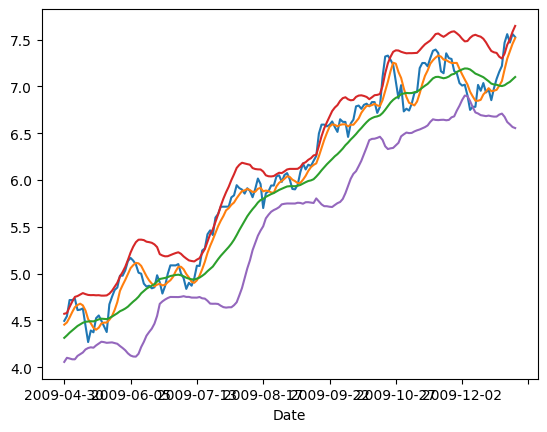

In [49]:
data['Close'].plot()
data['MA5'].plot()
data['MA20'].plot()
data['BB_upper'].plot()
data['BB_lower'].plot()

# 3. State Space Matrix (copy from training code)

In [80]:
# Construct the State Space Matrix
dataset = data.reset_index()[['Date', 'Close', 'MA5', 'MA20', 'BB_upper', 'BB_lower', 'Vol20']]
dataset = data.reset_index()[['Date', 'Close', 'BB_upper', 'BB_lower']]
display_df(dataset)

,Date,Close,BB_upper,BB_lower
0,2009-04-30,4.493929,4.570118,4.055596
1,2009-05-01,4.544286,4.578017,4.099590
2,2009-05-04,4.716786,4.642685,4.092351
3,2009-05-05,4.716786,4.699974,4.083704
4,2009-05-06,4.732143,4.750376,4.083481
5,2009-05-07,4.609286,4.759484,4.119873
6,2009-05-08,4.613929,4.775274,4.138440
7,2009-05-11,4.627500,4.790938,4.156169
8,2009-05-12,4.443571,4.780187,4.188741
9,2009-05-13,4.267500,4.771407,4.204128


# 4. Normalize (Match normalizer from training)

,Date,Close,BB_upper,BB_lower
0,2009-04-30,4.493929,4.570118,4.055596
1,2009-05-01,4.544286,4.578017,4.099590
2,2009-05-04,4.716786,4.642685,4.092351
3,2009-05-05,4.716786,4.699974,4.083704
4,2009-05-06,4.732143,4.750376,4.083481
5,2009-05-07,4.609286,4.759484,4.119873
6,2009-05-08,4.613929,4.775274,4.138440
7,2009-05-11,4.627500,4.790938,4.156169
8,2009-05-12,4.443571,4.780187,4.188741
9,2009-05-13,4.267500,4.771407,4.204128


<Axes: >

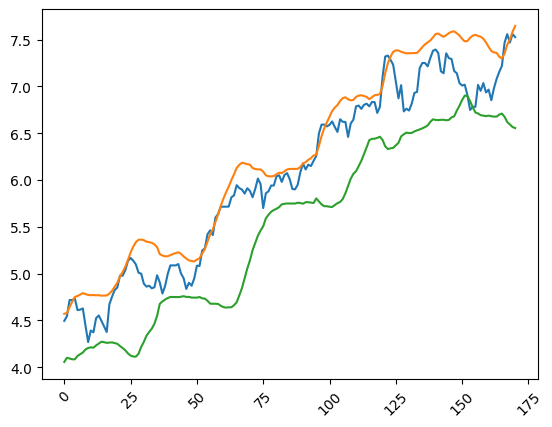

In [81]:
# Display & Plot Un-normalized Dataset
display_df(dataset)
dataset['Close'].plot()
dataset['BB_upper'].plot()
dataset['BB_lower'].plot(rot=45)

In [82]:
# Normalize Dataset with StandardScaler
normlist = []
static_normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    if col == 'Date':
        static_normed_dataset[col] = dataset[col]
        continue
    normalizer = StandardScaler()
    column_data = pd.DataFrame(dataset[col])
    normalizer.fit(column_data)
    static_normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

,Date,Close,BB_upper,BB_lower
0,2009-04-30,-1.608746,-1.687748,-1.526756
1,2009-05-01,-1.556090,-1.679774,-1.480366
2,2009-05-04,-1.375714,-1.614489,-1.488000
3,2009-05-05,-1.375714,-1.556652,-1.497117
4,2009-05-06,-1.359656,-1.505769,-1.497353
5,2009-05-07,-1.488122,-1.496574,-1.458979
6,2009-05-08,-1.483268,-1.480633,-1.439401
7,2009-05-11,-1.469077,-1.464820,-1.420707
8,2009-05-12,-1.661403,-1.475673,-1.386361
9,2009-05-13,-1.845513,-1.484537,-1.370136


<Axes: >

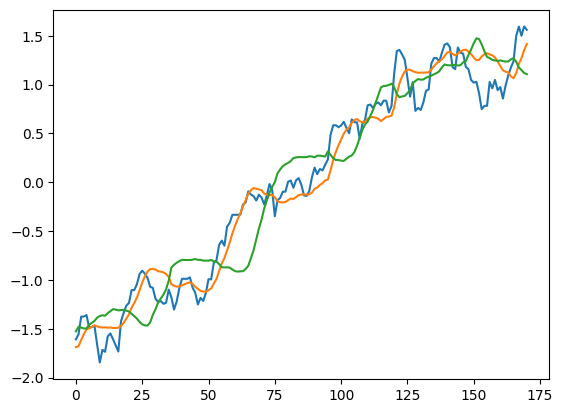

In [83]:
# Plot Normalized Features: Close, MA20, BB Upper, BB Lower
display_df(static_normed_dataset)
static_normed_dataset['Close'].plot()
static_normed_dataset['BB_upper'].plot()
static_normed_dataset['BB_lower'].plot()

# 5. Type Conversion

In [84]:
X_backtest = static_normed_dataset.set_index('Date').values.astype(float)
X_backtest.shape

(171, 3)

# 6. Agent Class and Helper Functions (copy from training code)

In [60]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()


    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)   
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        options = self.get_q_values_for_state(state)
        return np.argmax(options[0]) 

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)  
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # define epsilon decay (for the act function)     
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

In [95]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    # if train:
    #     plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    # else:
    #     plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/2)), test_df.index.values[0::int(len(test_df.index.values)/2)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()
    

# returns an an n-day state representation ending at time t
def get_state(data, t, n):    
    d = t - n
    if d >= 0:
        block = data[d:t] 
    else:
        block =  np.array([data[0]]*n) 
    res = []
    for i in range(n - 1):
        feature_res = []
        for feature in range(data.shape[1]):
            feature_res.append(sigmoid(block[i + 1, feature] - block[i, feature]))
        res.append(feature_res)
    # display(res)
    return np.array([res])

# Define Parameters

In [107]:
window_size = 1
episode_to_load = 5

l_test = len(X_backtest) - 1
state = get_state(X_backtest, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_backtest.shape[1], test_mode=True, model_name=f'model_ep{episode_to_load}.keras')
agent.inventory = []

# Define Normalizers to inverse price

In [108]:
idx_close = 0
idx_bb_upper = 1 
idx_bb_lower = 2

In [109]:
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

In [110]:
X_backtest

array([[-1.60874631e+00, -1.68774799e+00, -1.52675639e+00],
       [-1.55609027e+00, -1.67977404e+00, -1.48036649e+00],
       [-1.37571422e+00, -1.61448876e+00, -1.48799985e+00],
       [-1.37571422e+00, -1.55665206e+00, -1.49711745e+00],
       [-1.35965604e+00, -1.50576888e+00, -1.49735294e+00],
       [-1.48812248e+00, -1.49657412e+00, -1.45897915e+00],
       [-1.48326753e+00, -1.48063305e+00, -1.43940129e+00],
       [-1.46907664e+00, -1.46481972e+00, -1.42070678e+00],
       [-1.66140334e+00, -1.47567301e+00, -1.38636117e+00],
       [-1.84551348e+00, -1.48453691e+00, -1.37013616e+00],
       [-1.71630062e+00, -1.48688796e+00, -1.36203177e+00],
       [-1.73609288e+00, -1.48599161e+00, -1.36673387e+00],
       [-1.57812428e+00, -1.48863852e+00, -1.34080899e+00],
       [-1.54824766e+00, -1.48732907e+00, -1.32074865e+00],
       [-1.60725298e+00, -1.49207262e+00, -1.29937484e+00],
       [-1.67036582e+00, -1.49203734e+00, -1.30400604e+00],
       [-1.73310522e+00, -1.48972713e+00

In [111]:
X_backtest_true_price = normalizer_close.inverse_transform(X_backtest[:,idx_close].reshape(-1,1))
X_backtest_true_bb_upper = normalizer_close.inverse_transform(X_backtest[:,idx_bb_upper].reshape(-1,1))
X_backtest_true_bb_lower = normalizer_close.inverse_transform(X_backtest[:,idx_bb_lower].reshape(-1,1))


# Supplement test loop with trade tracking for post-analysis

In [112]:
trade_tracker = pd.DataFrame(columns=['Buy Price', 'Buy Timestamp', 'Sell Price', 'Sell Timestamp', 'Buy Volume', 'Buy MA20', 'Buy STD20']) 

In [113]:
trade_tracker

,Buy Price,Buy Timestamp,Sell Price,Sell Timestamp,Buy Volume,Buy MA20,Buy STD20


# Backtest loop

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sell: $4.49 | Profit: $0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Buy: $4.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Buy: $4.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Buy: $4.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Buy: $4.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Buy: $4.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Buy: $4.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sell: $4.52 | Profit: -$0.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Buy: $4.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Buy: $4.50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Buy: $4.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Buy: $4.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Buy: $4.85
1/1 ━━━━━━━━━━━━━━━━━━━━

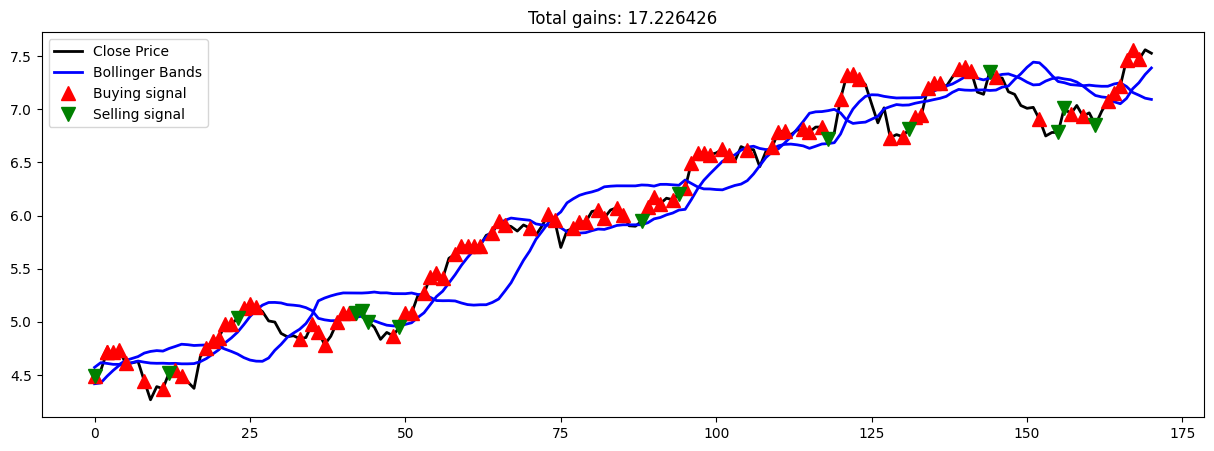

In [118]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_backtest, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        # inverse transform to get true buy price in dollars
        buy_price = normalizer_close.inverse_transform([[X_backtest[t, idx_close]]])[0][0]
        # buy_price = X_backtest[t, idx_close]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

        date = static_normed_dataset.iloc[t]['Date']
        trade_tracker.loc[len(states_buy_test), 'Buy Price'] = buy_price
        trade_tracker.loc[len(states_buy_test), 'Buy Timestamp'] = date
        trade_tracker.loc[len(states_buy_test), 'Buy Volume'] = data.loc[date, 'Volume']
        trade_tracker.loc[len(states_buy_test), 'Buy MA20'] = data.loc[date, 'MA20']
        trade_tracker.loc[len(states_buy_test), 'Buy STD20'] = data.loc[date, 'STD20']

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)  
        # inverse transform to get true sell price in dollars
        # sell_price = X_testback[t, idx_close]
        sell_price = normalizer_close.inverse_transform([[X_backtest[t, idx_close]]])[0][0]
        
        # reward is max of profit (close price at time of sell - close price at time of buy)
        reward = max(sell_price - bought_price, 0)
        total_profit += sell_price - bought_price
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

        date = static_normed_dataset.iloc[t]['Date']
        trade_tracker.loc[len(states_sell_test), 'Sell Price'] = buy_price
        trade_tracker.loc[len(states_sell_test), 'Sell Timestamp'] = date


    if t == l_test - 1:
        done = True
    
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_backtest_true_price,X_backtest_true_bb_upper,X_backtest_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)

In [119]:
trade_tracker

,Buy Price,Buy Timestamp,Sell Price,Sell Timestamp,Buy Volume,Buy MA20,Buy STD20
1,4.716786,2009-05-04,4.493929,2009-04-30,NaN,NaN,NaN
2,4.493929,2009-04-30,4.372143,2009-05-18,498489600.0,4.312857,0.128631
3,4.716786,2009-05-04,4.976786,2009-06-03,609358400.0,4.367518,0.137583
4,4.716786,2009-05-05,5.087143,2009-06-30,609358400.0,4.391839,0.154067
5,4.732143,2009-05-06,5.087143,2009-07-01,473538800.0,4.416929,0.166724
6,4.609286,2009-05-07,5.087143,2009-07-02,531776000.0,4.439679,0.159903
7,4.443571,2009-05-12,4.87,2009-07-10,609481600.0,4.484464,0.147862
8,4.372143,2009-05-15,6.0075,2009-09-03,367567200.0,4.488661,0.140653
9,4.551786,2009-05-19,6.148571,2009-09-14,372422400.0,4.509804,0.129419
10,4.495357,2009-05-20,6.831786,2009-10-16,388584000.0,4.517589,0.123177
